In [28]:
import warnings
warnings.filterwarnings("ignore")
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_curve, auc, accuracy_score, classification_report, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.svm import SVR
print('Autor/Engineer: Adeola Odunewu')

Autor/Engineer: Adeola Odunewu


In [29]:
# Assiging url and load data 
url = 'https://github.com/FlipRoboTechnologies/ML-Datasets/raw/main/Grades/Grades.csv'
df = pd.read_csv(url)
df.head()

,Seat No.,PH-121,HS-101,CY-105,HS-105/12,MT-111,CS-105,CS-106,EL-102,EE-119,...,CS-312,CS-317,CS-403,CS-421,CS-406,CS-414,CS-419,CS-423,CS-412,CGPA
0,CS-97001,B-,D+,C-,C,C-,D+,D,C-,B-,...,C-,C-,C-,C-,A-,A,C-,B,A-,2.205
1,CS-97002,A,D,D+,D,B-,C,D,A,D+,...,D+,D,C,D,A-,B-,C,C,B,2.008
2,CS-97003,A,B,A,B-,B+,A,B-,B+,A-,...,B,B,A,C,A,A,A,A-,A,3.608
3,CS-97004,D,C+,D+,D,D,A-,D+,C-,D,...,D+,C,D+,C-,B-,B,C+,C+,C+,1.906
4,CS-97005,A-,A-,A-,B+,A,A,A-,B+,A,...,B-,B+,B+,B-,A-,A,A-,A-,A,3.448


In [8]:
df.dtypes

Seat No.      object
PH-121        object
HS-101        object
CY-105        object
HS-105/12     object
MT-111        object
CS-105        object
CS-106        object
EL-102        object
EE-119        object
ME-107        object
CS-107        object
HS-205/20     object
MT-222        object
EE-222        object
MT-224        object
CS-210        object
CS-211        object
CS-203        object
CS-214        object
EE-217        object
CS-212        object
CS-215        object
MT-331        object
EF-303        object
HS-304        object
CS-301        object
CS-302        object
TC-383        object
MT-442        object
EL-332        object
CS-318        object
CS-306        object
CS-312        object
CS-317        object
CS-403        object
CS-421        object
CS-406        object
CS-414        object
CS-419        object
CS-423        object
CS-412        object
CGPA         float64
dtype: object

In [3]:
df_na = df.isnull().sum()
df_na

Seat No.      0
PH-121        0
HS-101        0
CY-105        1
HS-105/12     1
MT-111        2
CS-105        0
CS-106        2
EL-102        2
EE-119        2
ME-107        2
CS-107        2
HS-205/20     5
MT-222        5
EE-222        7
MT-224        7
CS-210        7
CS-211        5
CS-203        5
CS-214        6
EE-217        6
CS-212        6
CS-215        6
MT-331        9
EF-303       10
HS-304       10
CS-301       10
CS-302       10
TC-383       10
MT-442       10
EL-332        9
CS-318        9
CS-306        9
CS-312       10
CS-317       12
CS-403       12
CS-421       12
CS-406       85
CS-414       13
CS-419       13
CS-423       14
CS-412       79
CGPA          0
dtype: int64

Handling:

I will be imputing missing values with the mode when the proportion of missing values is relatively low (less than 20%),
because it is grade data, there might not be significant outliers. 
Similarly, I will be dropping columns with missing data above a certain threshold (above 25%) is a common practice when the missingness is high.

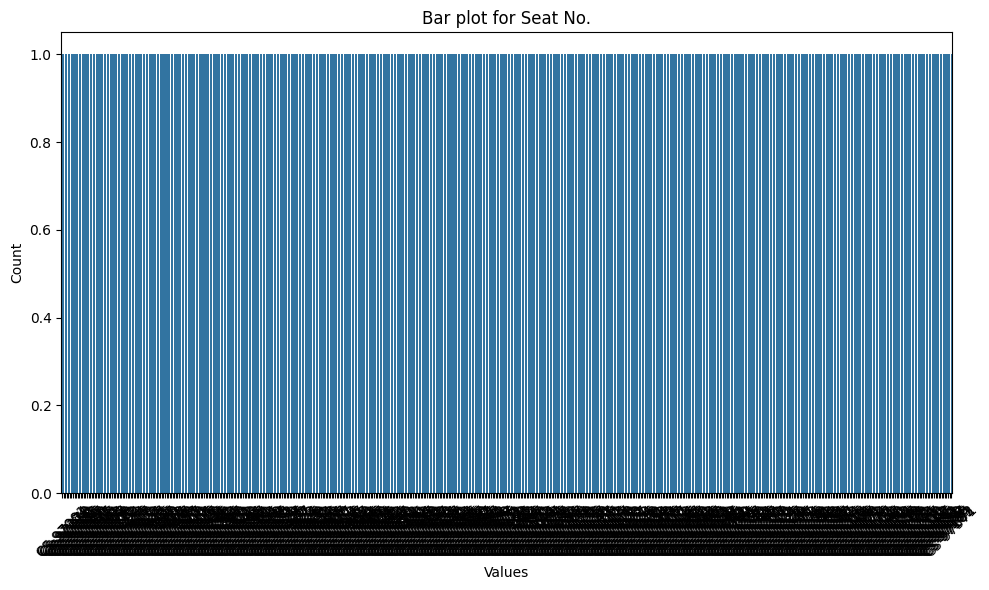

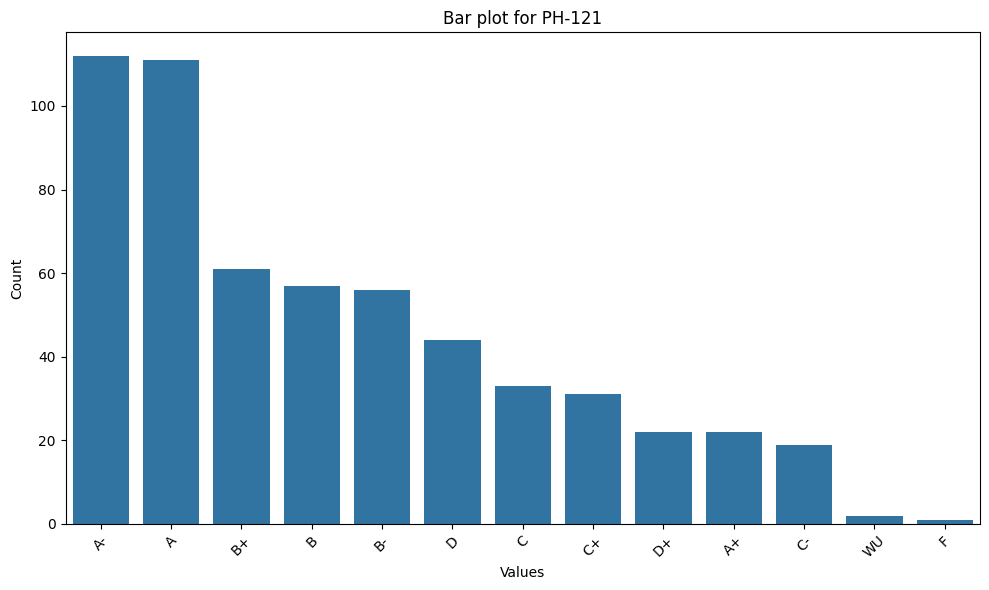

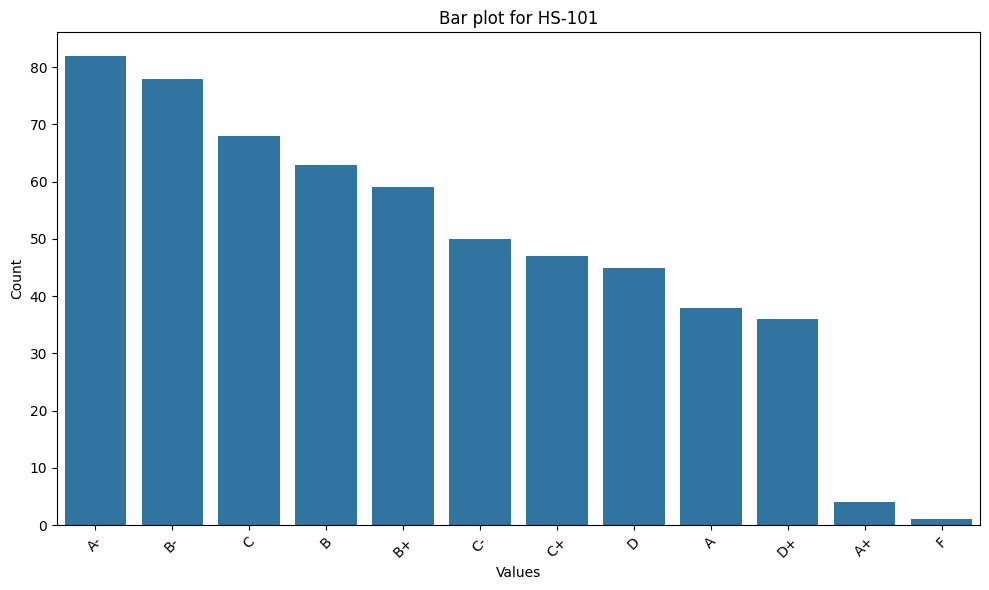

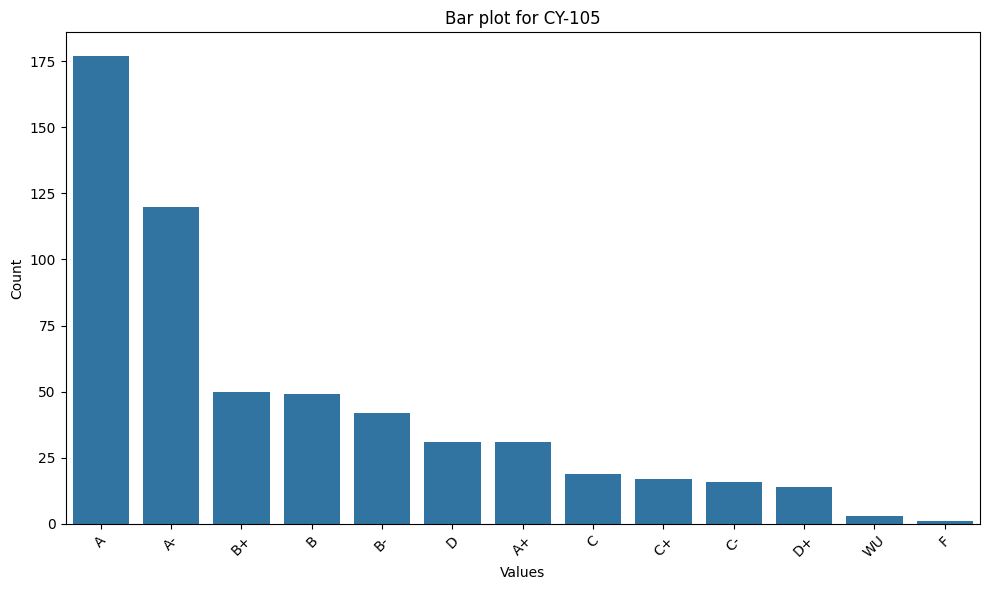

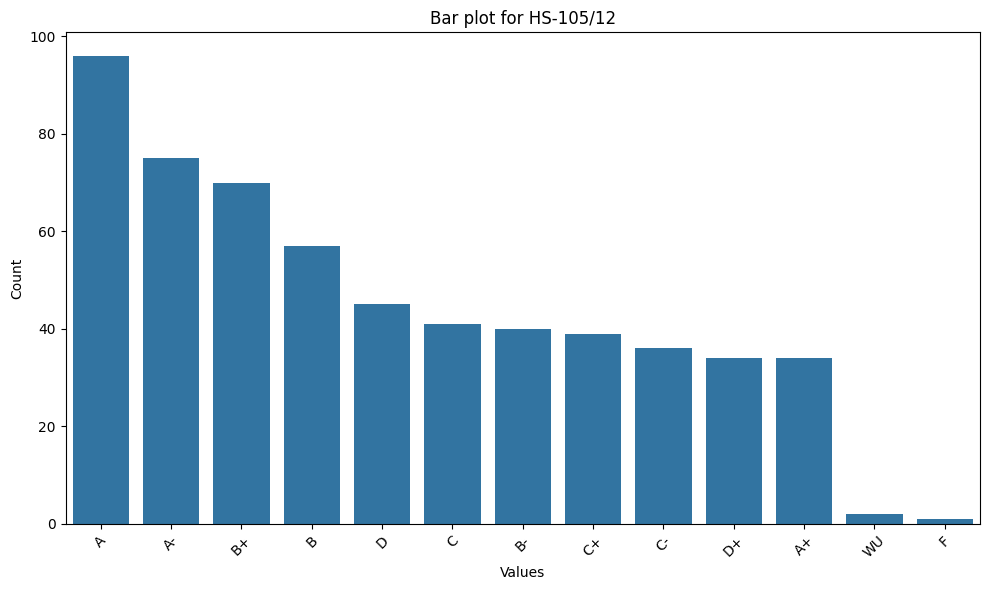

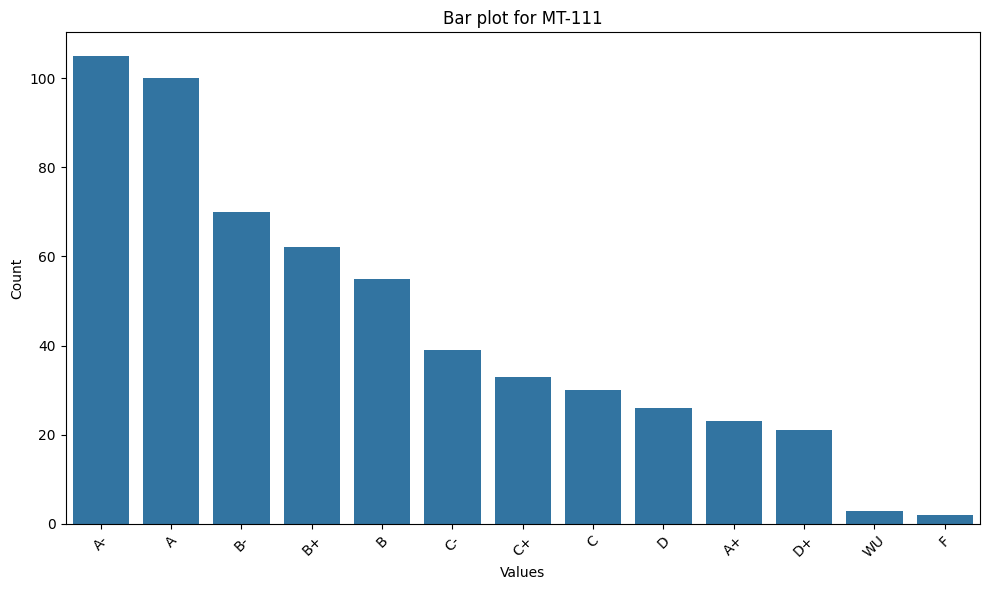

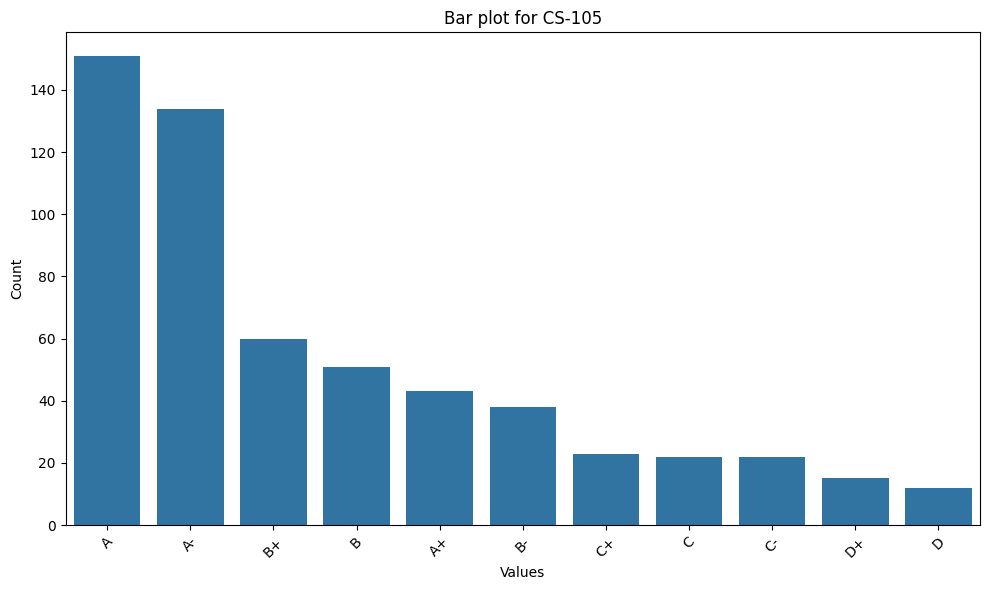

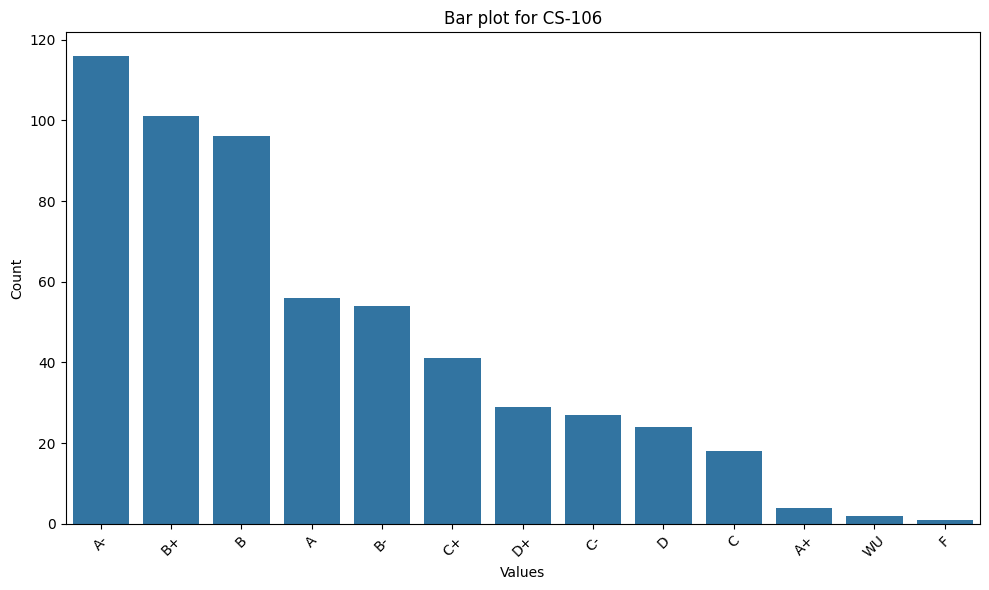

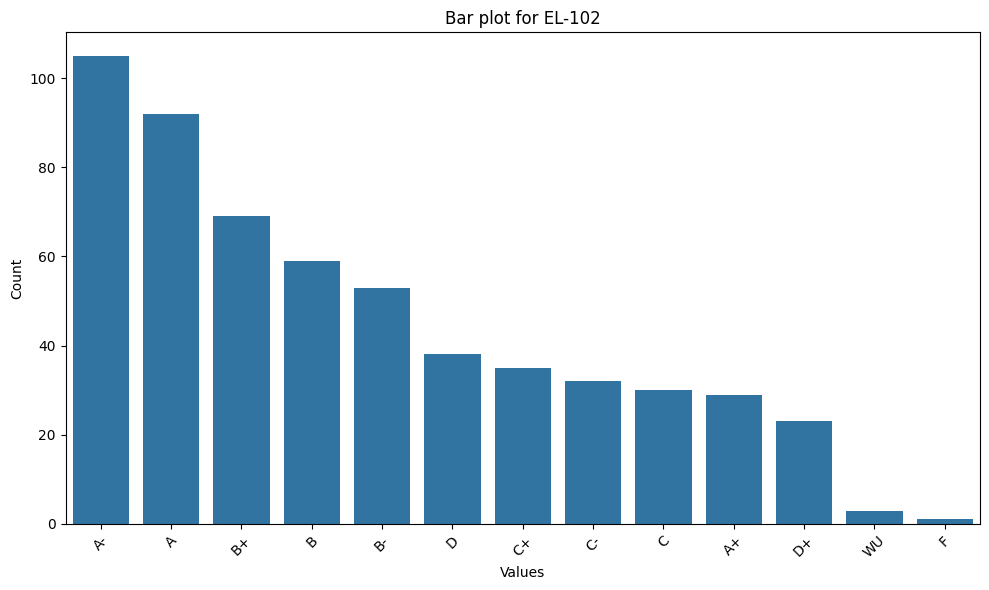

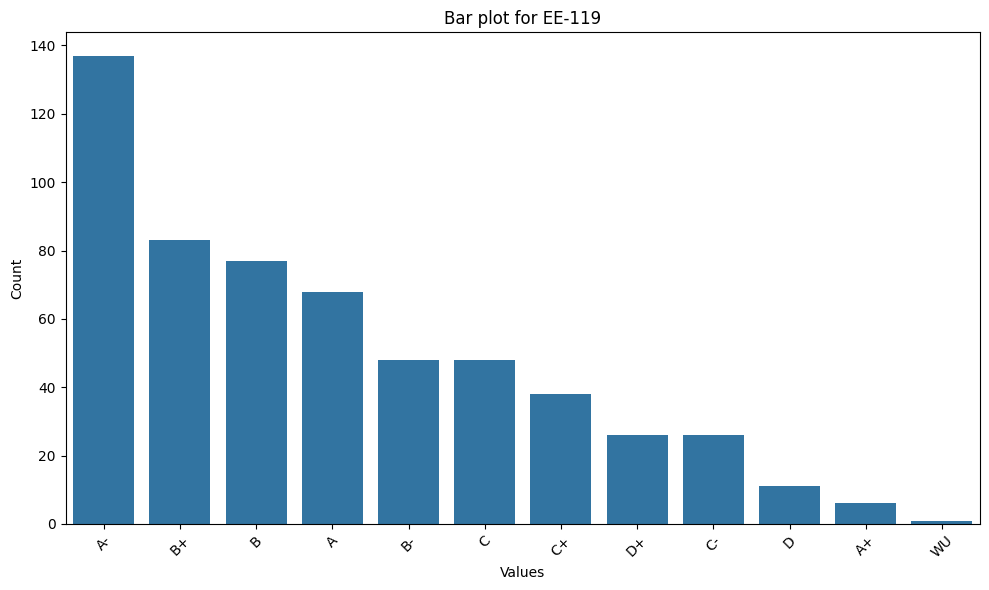

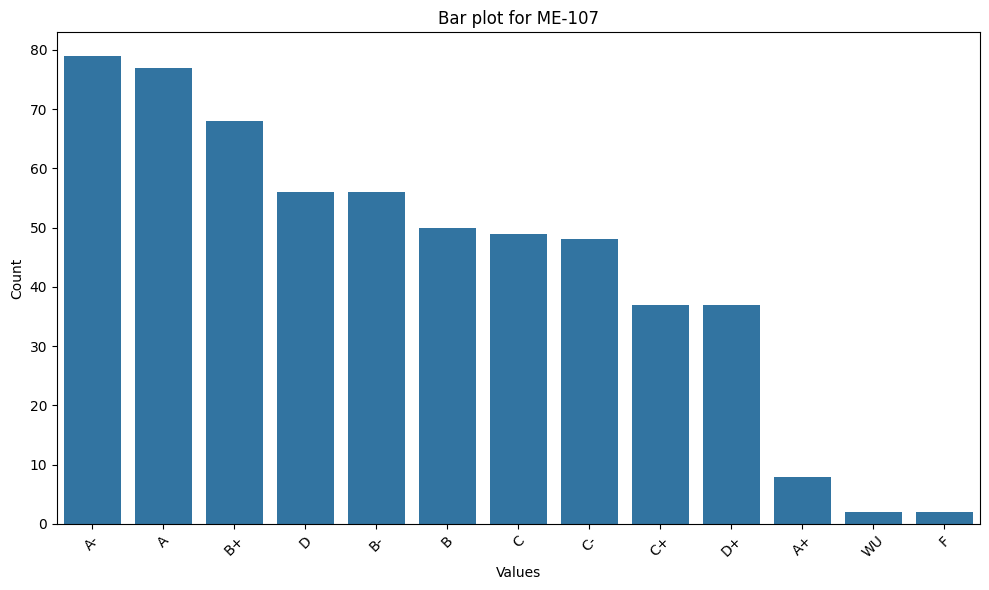

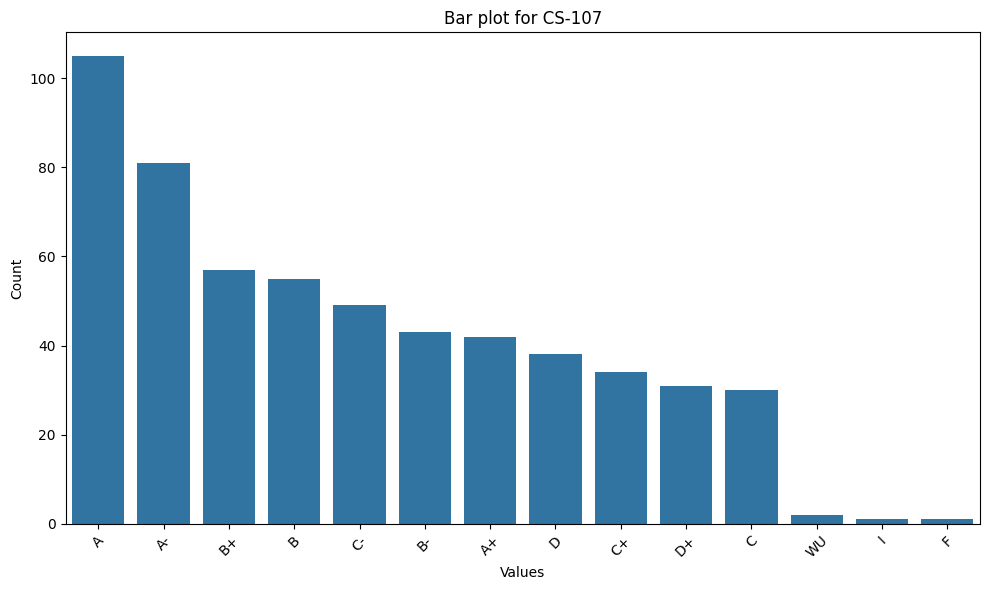

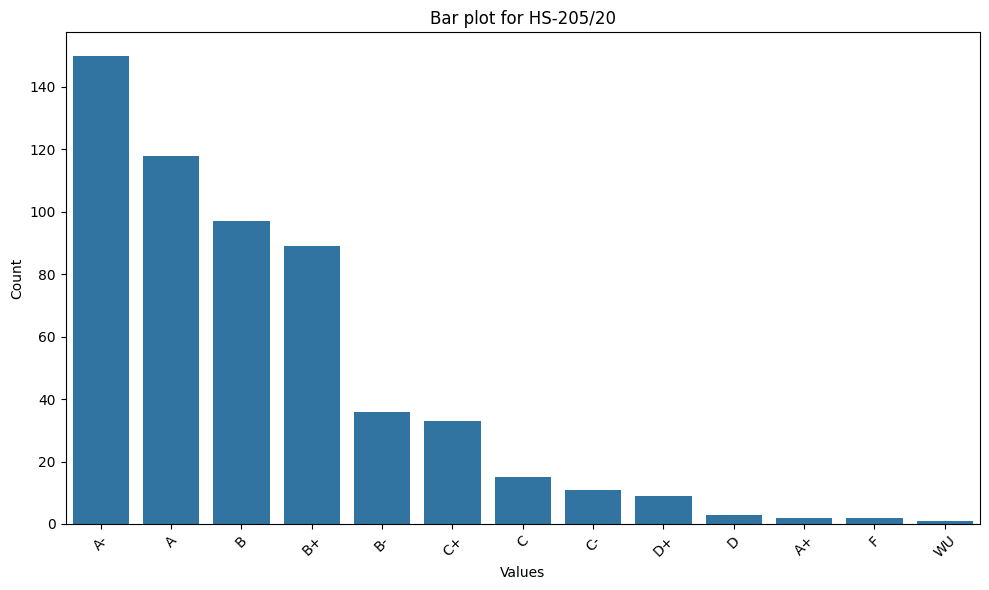

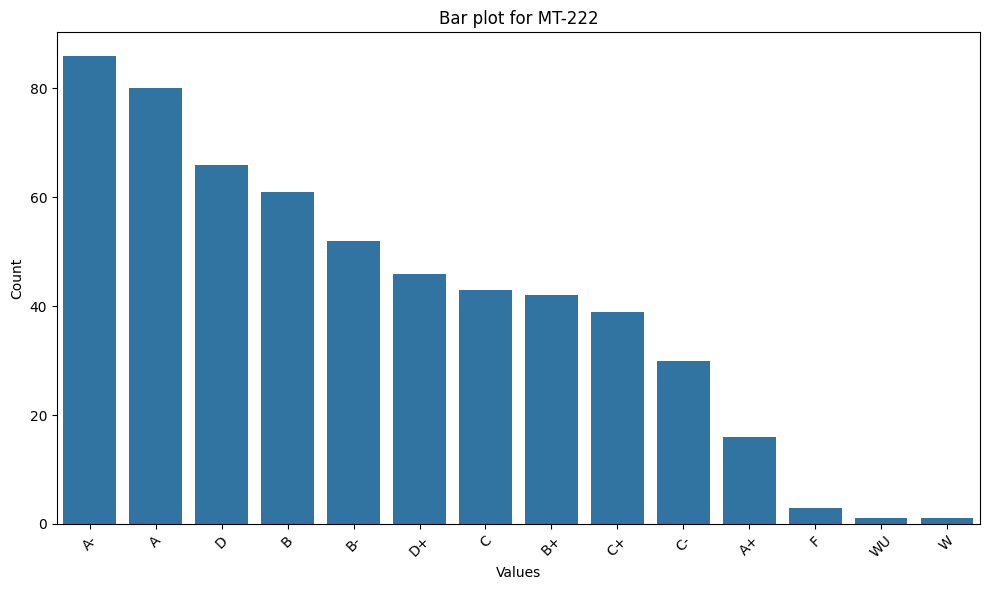

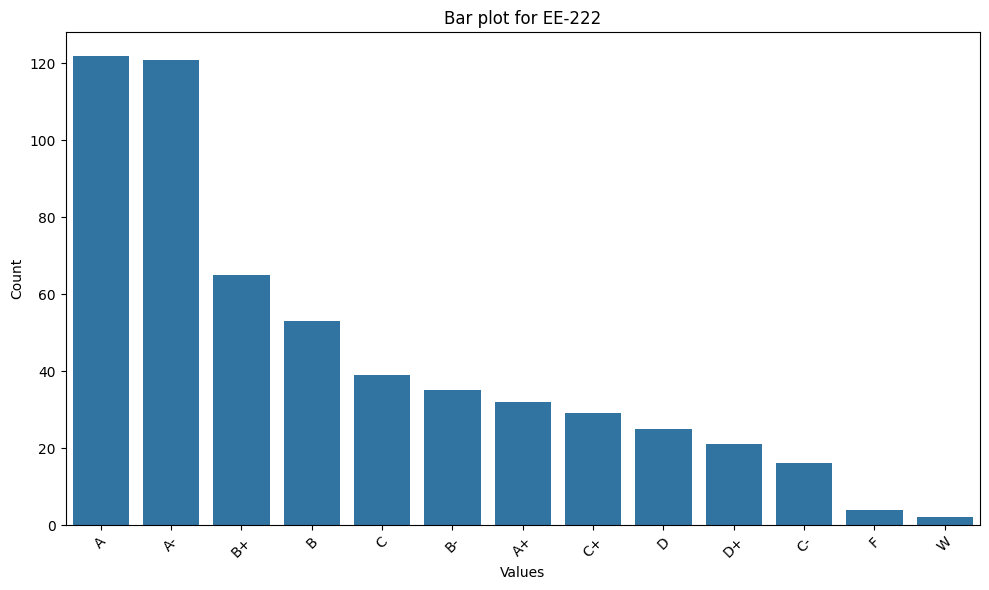

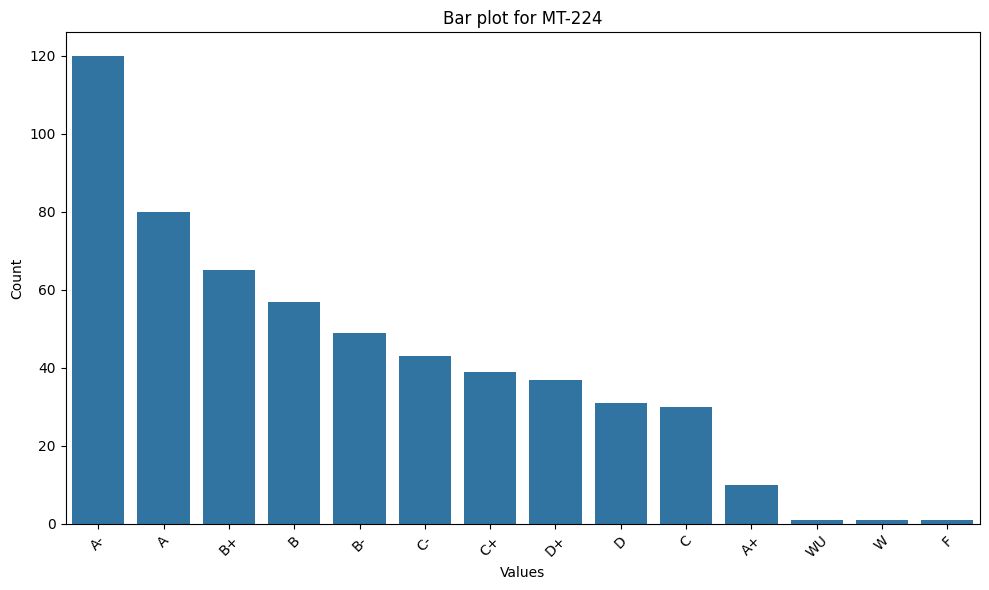

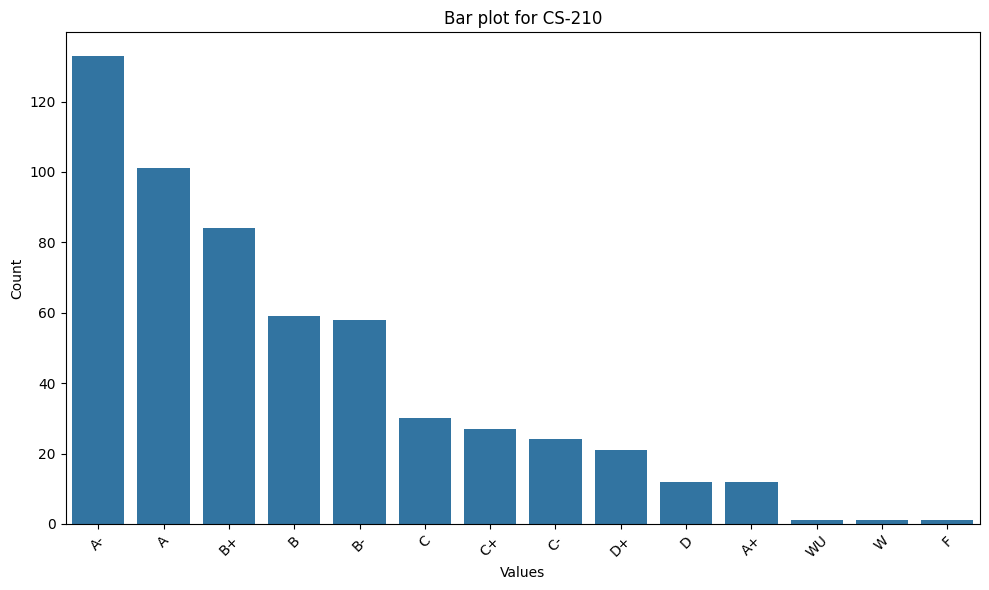

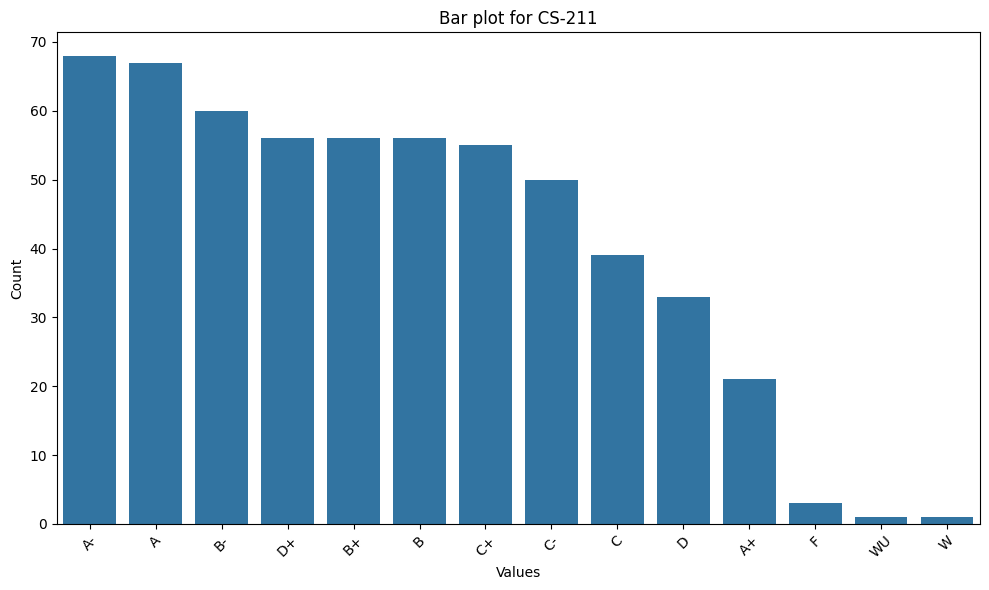

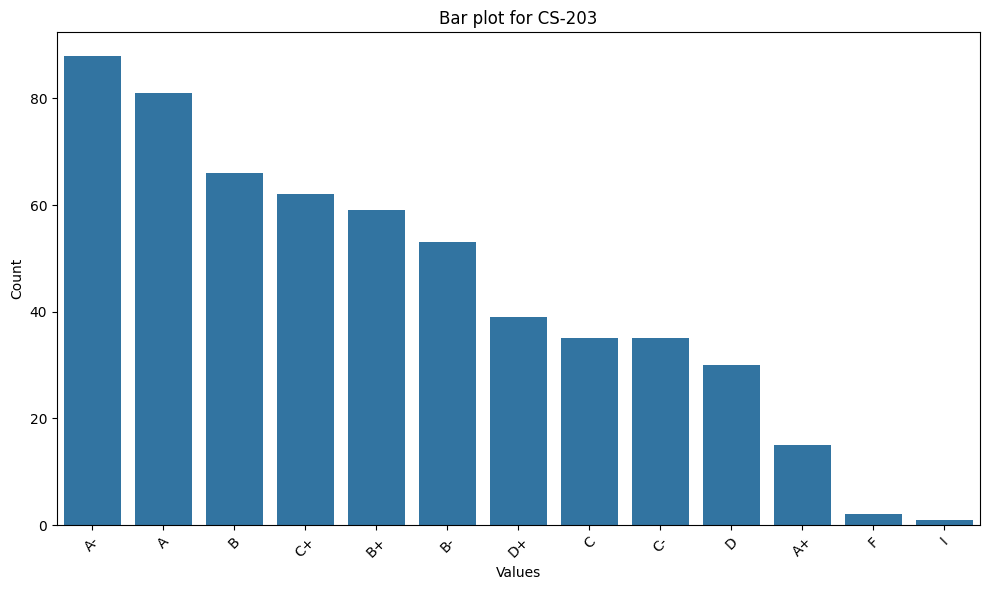

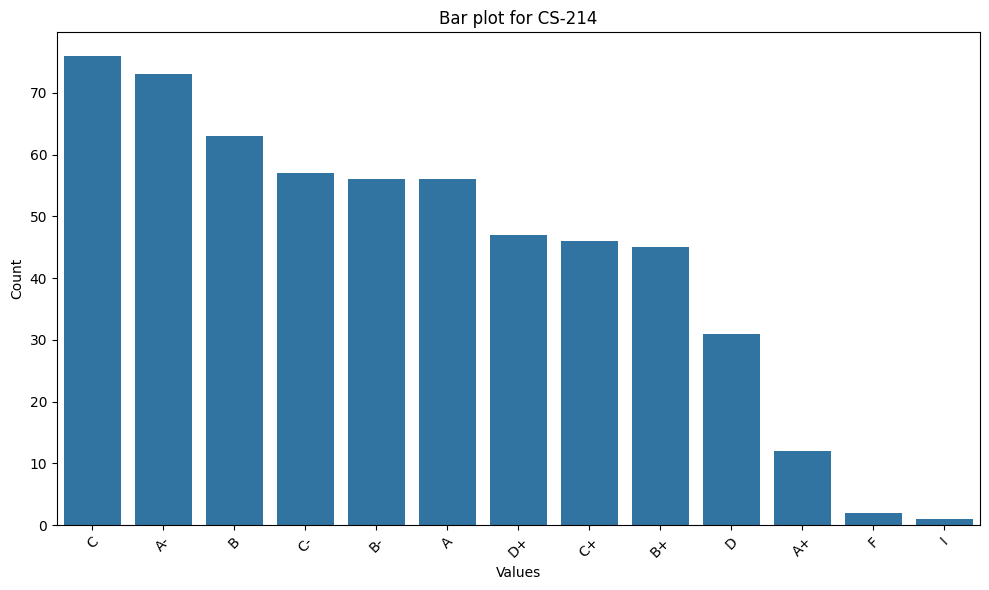

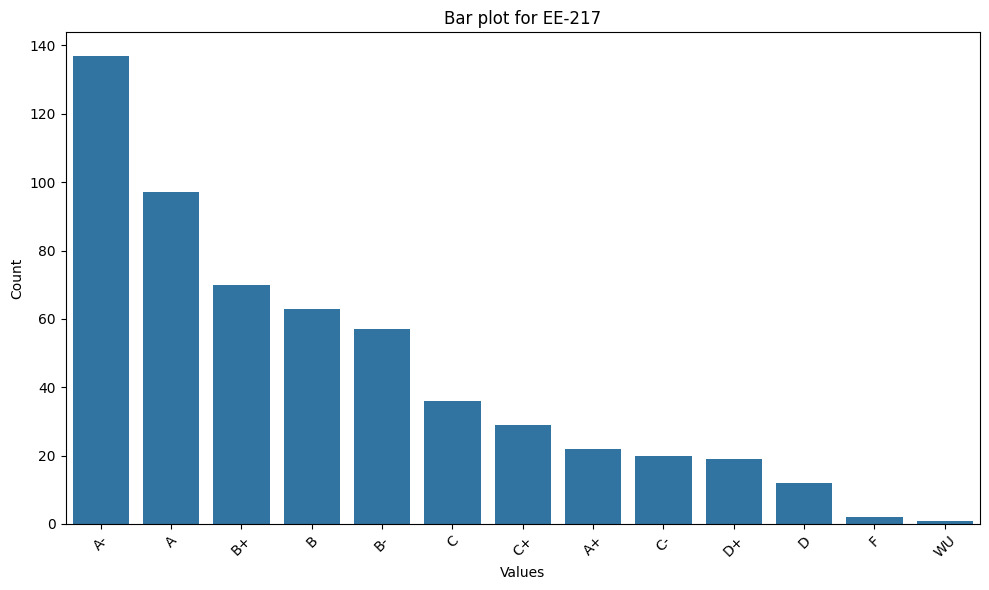

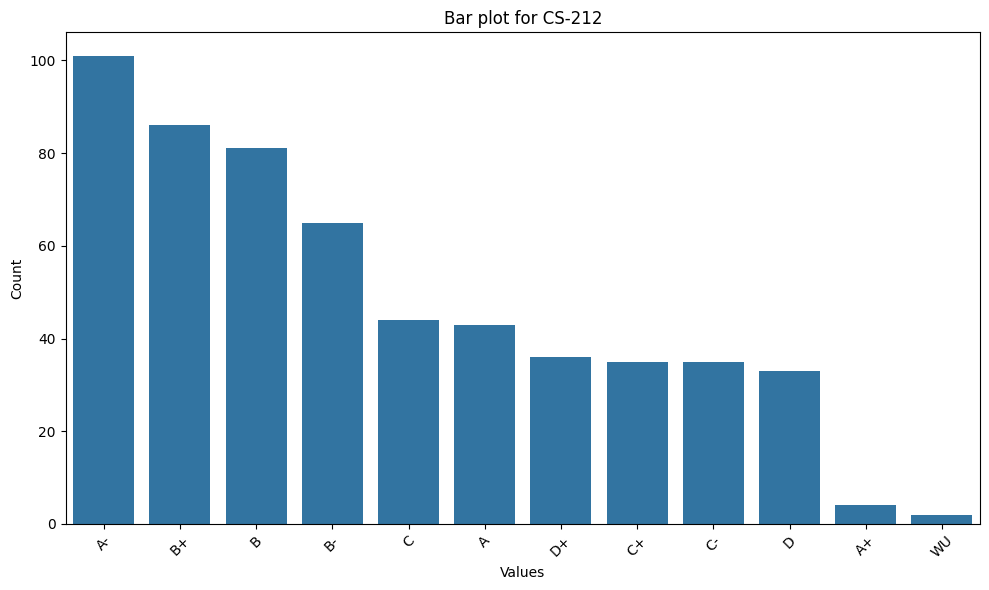

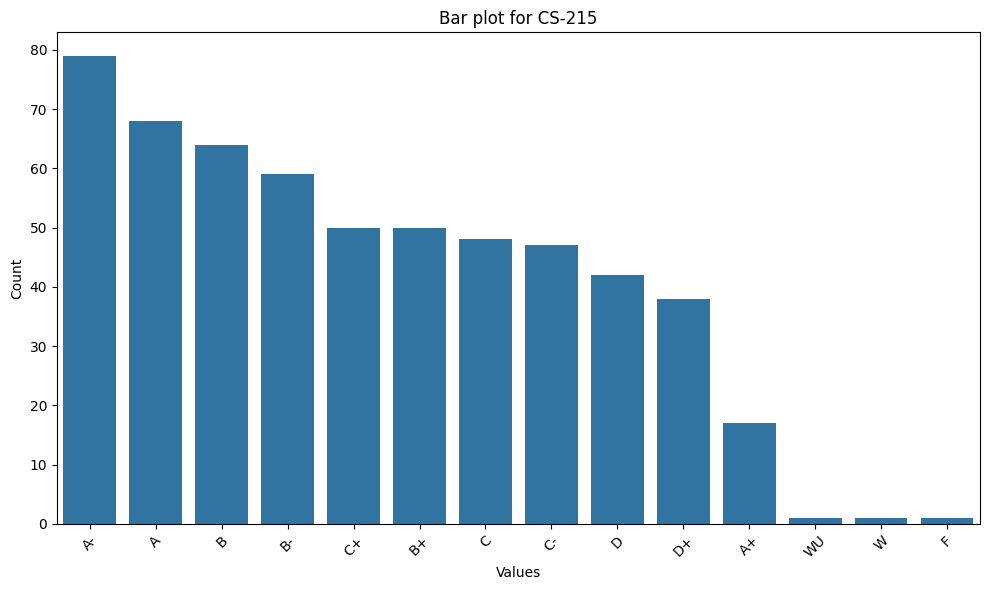

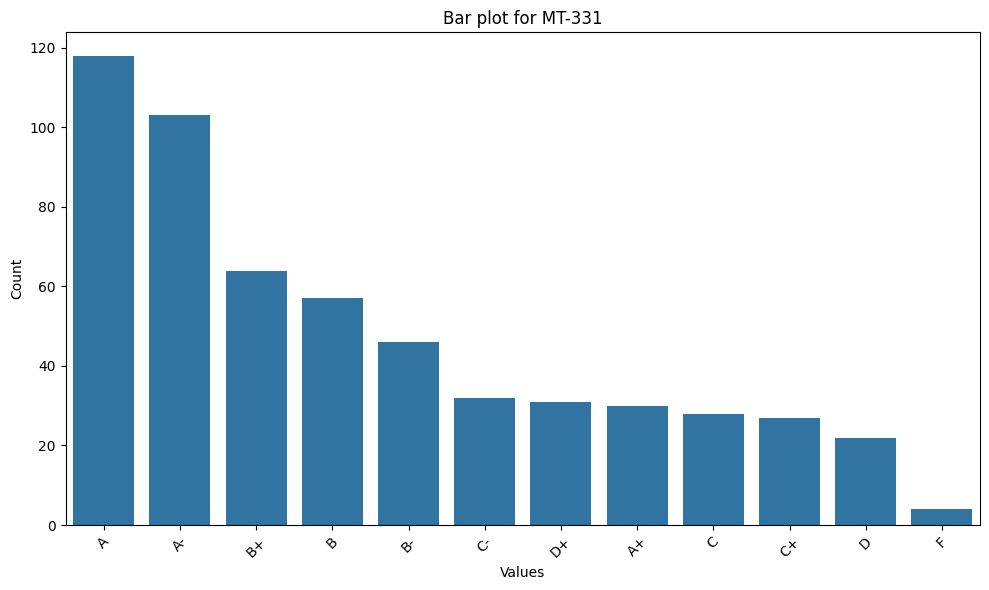

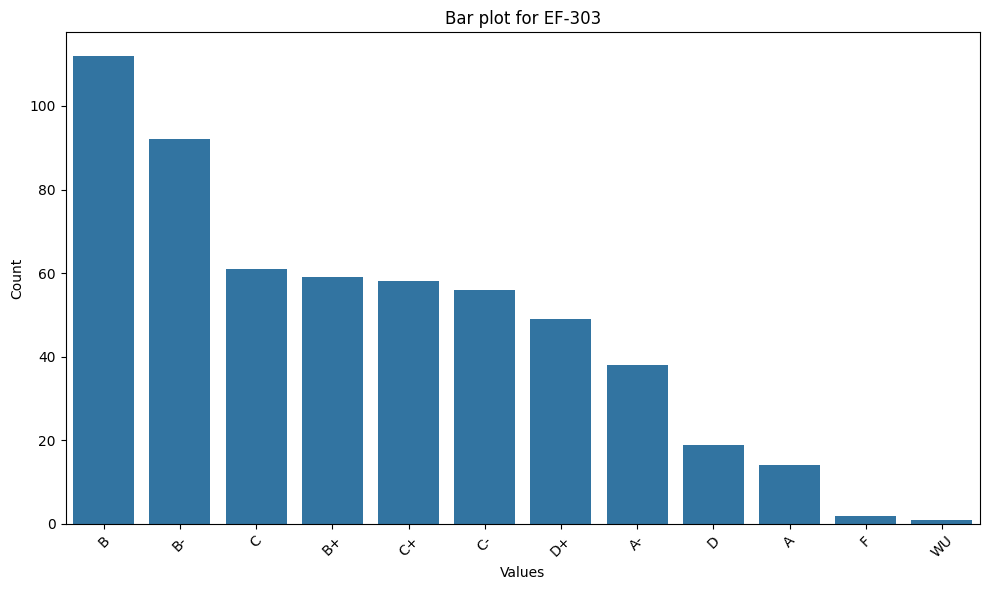

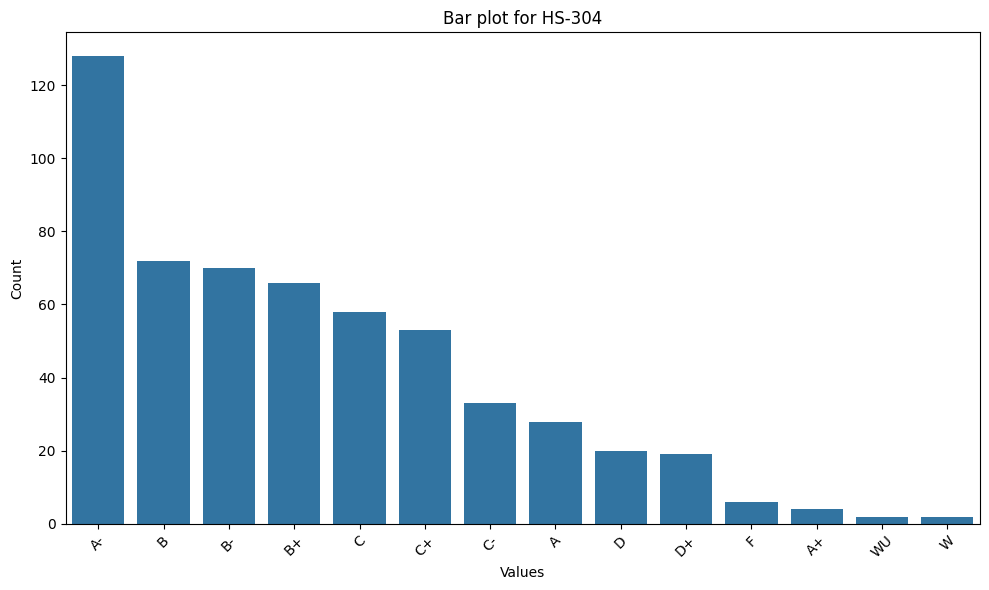

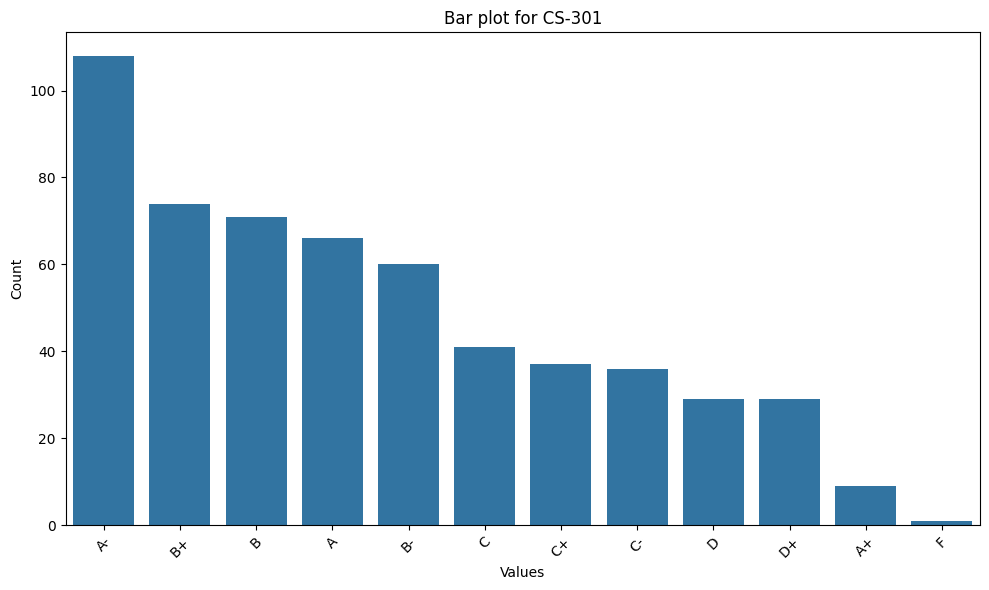

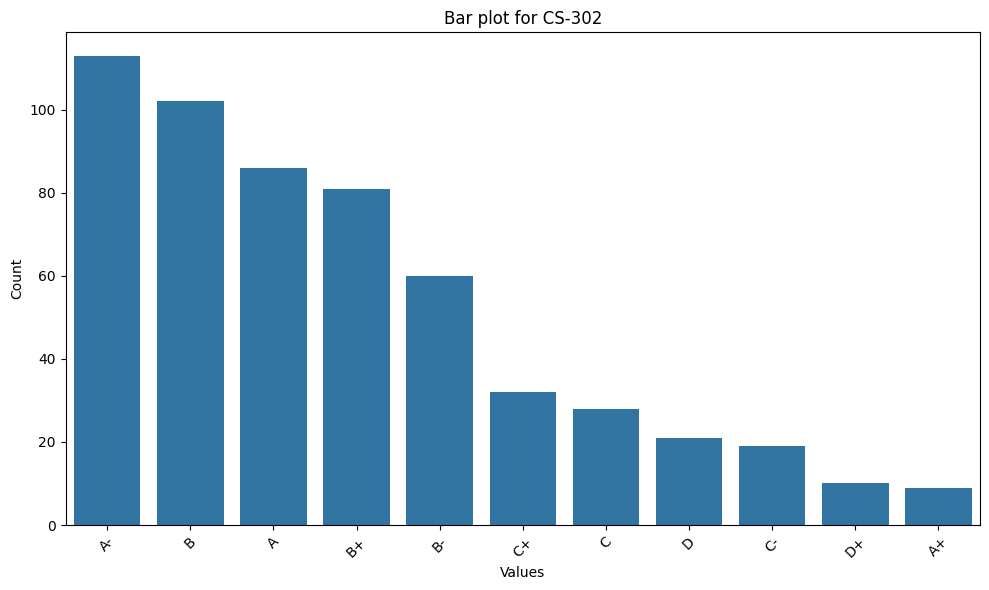

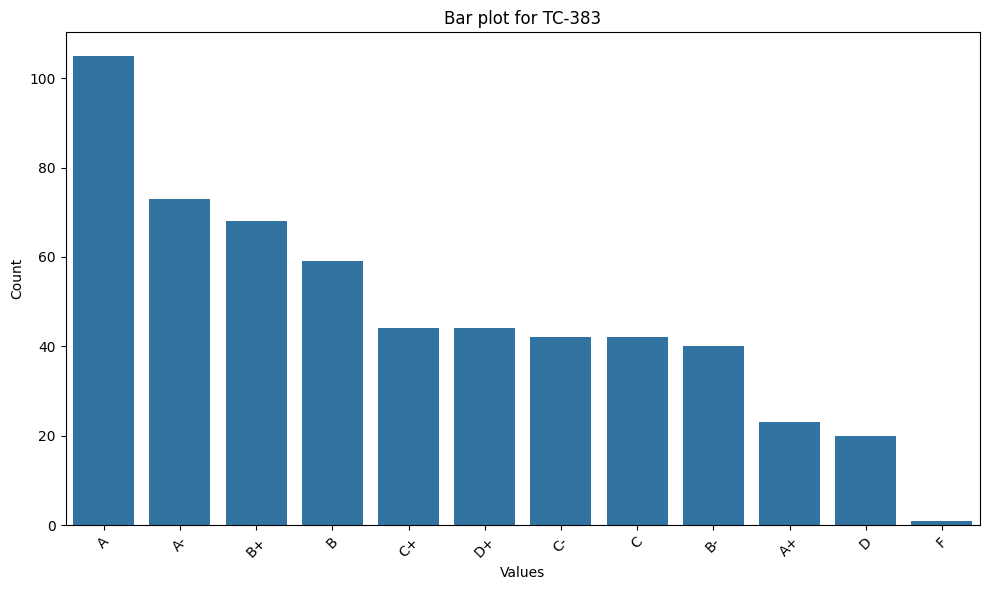

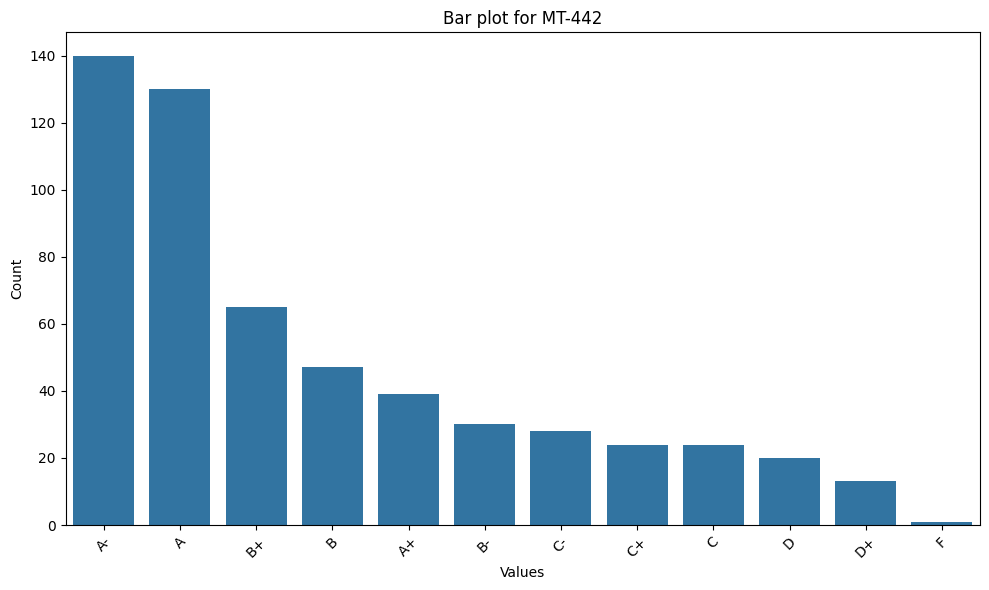

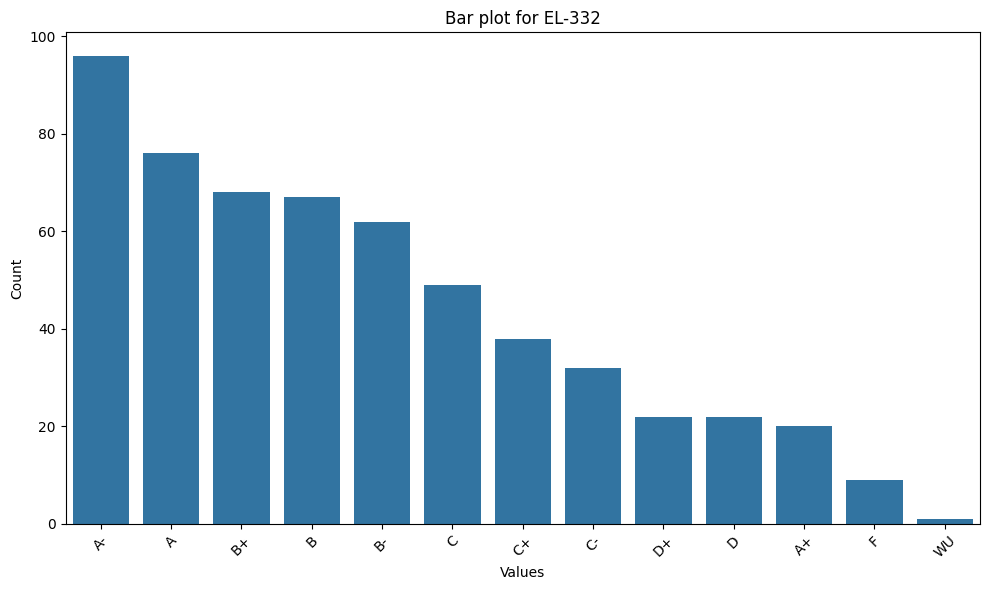

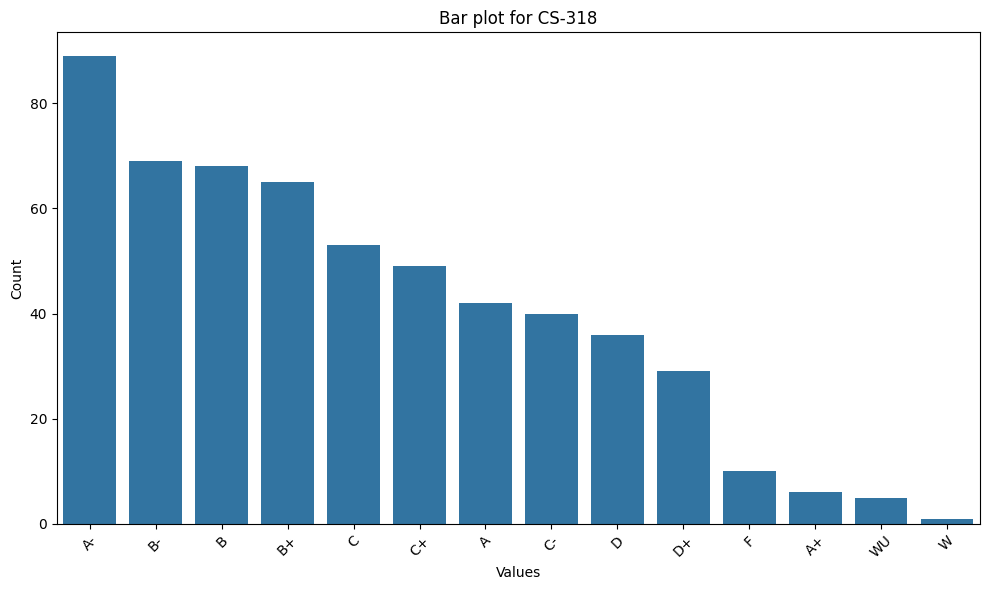

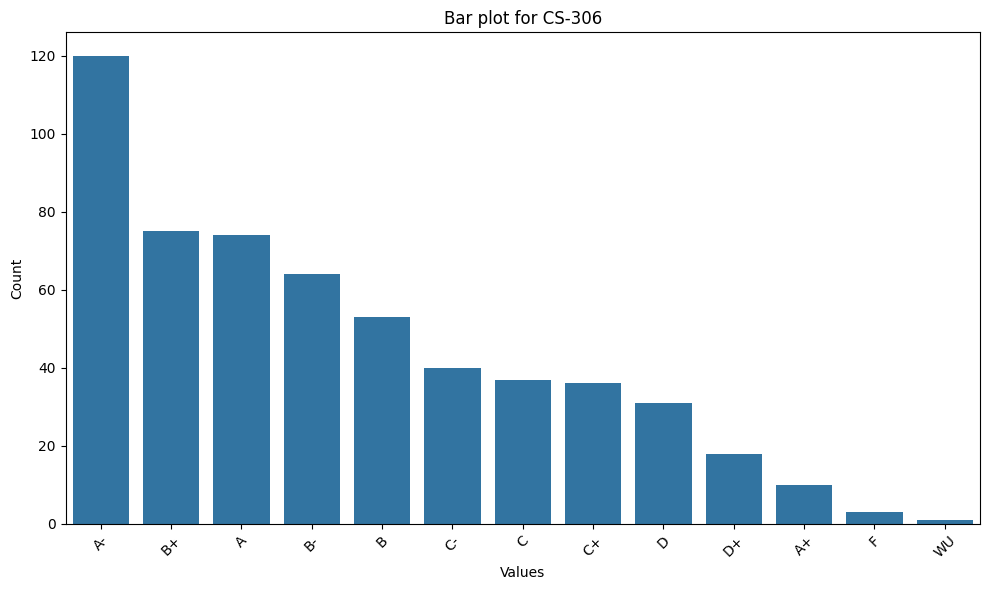

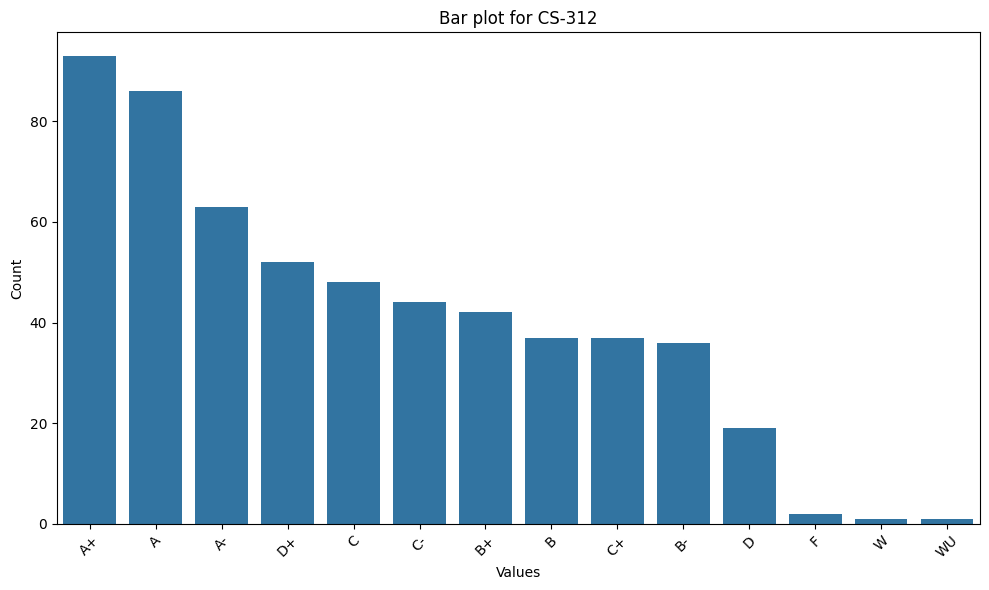

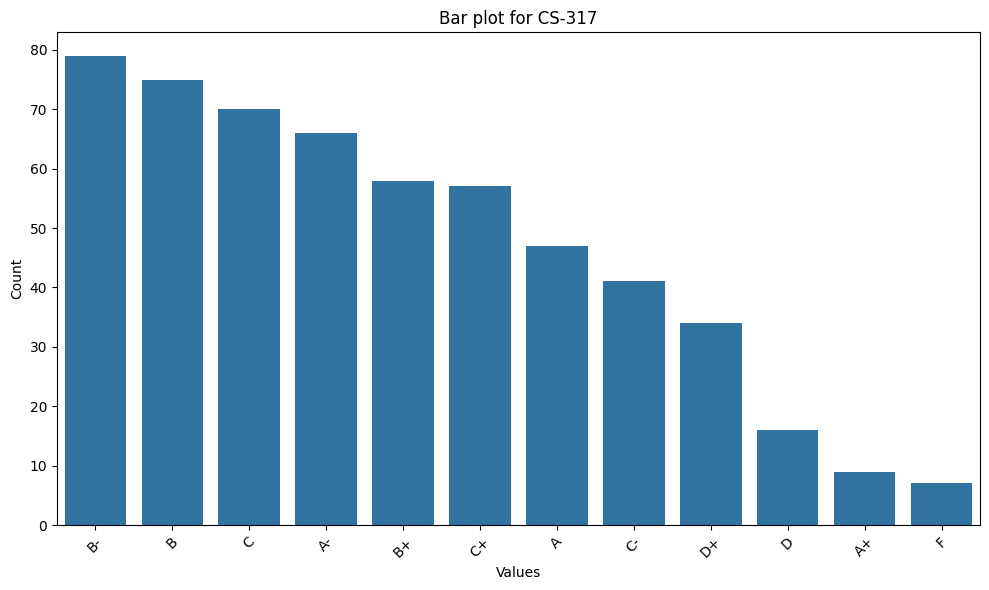

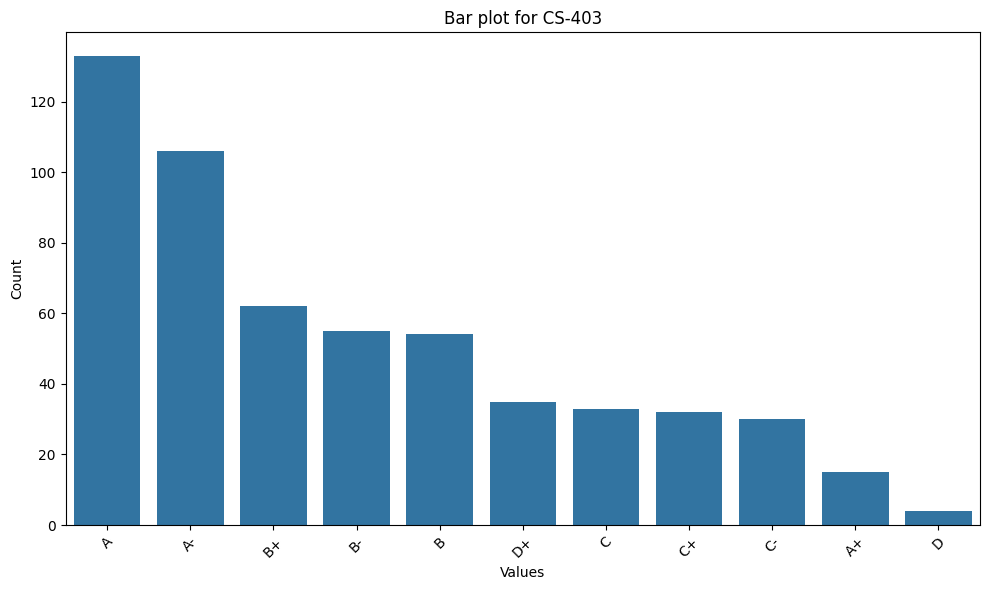

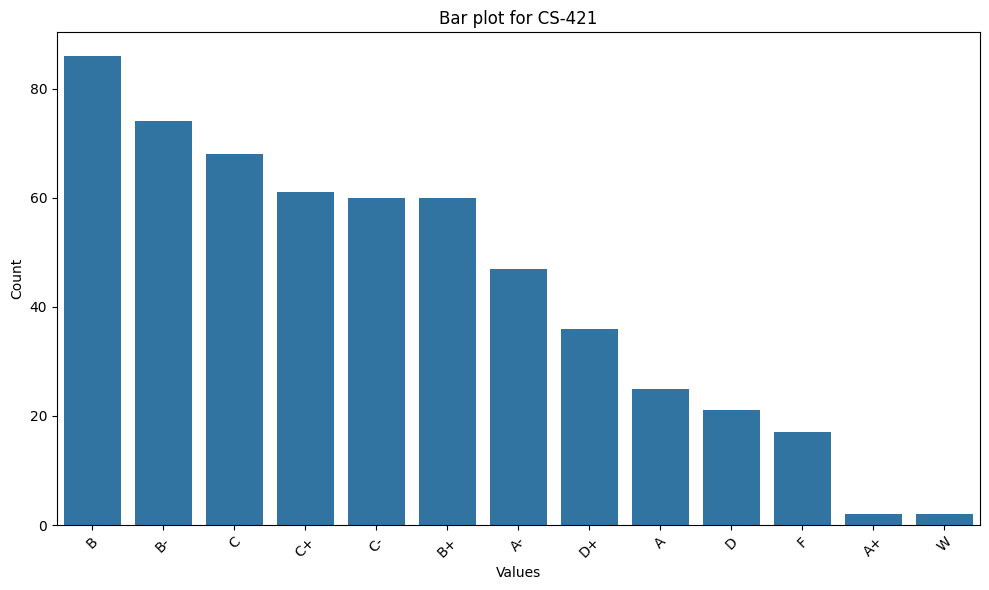

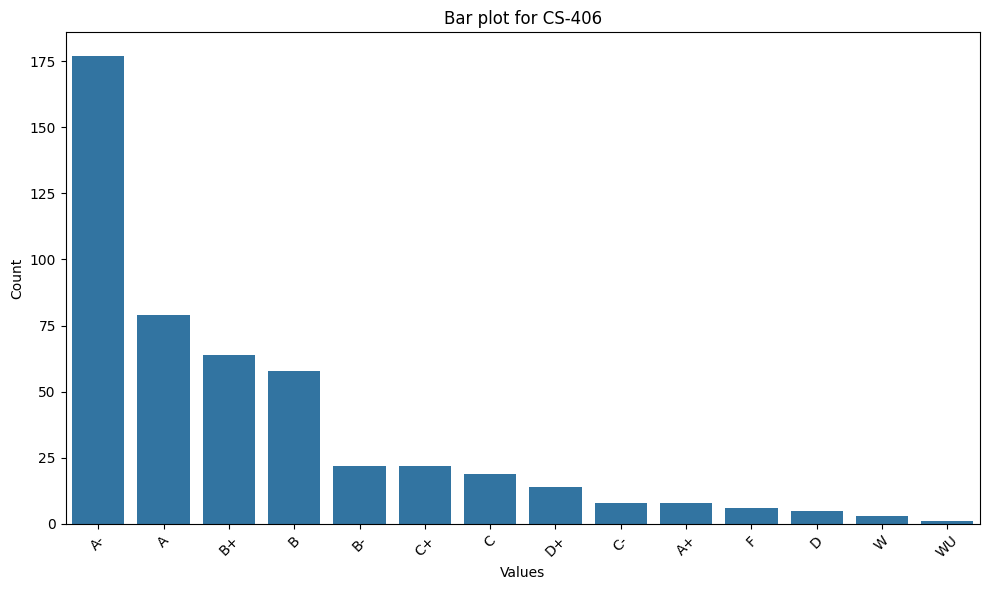

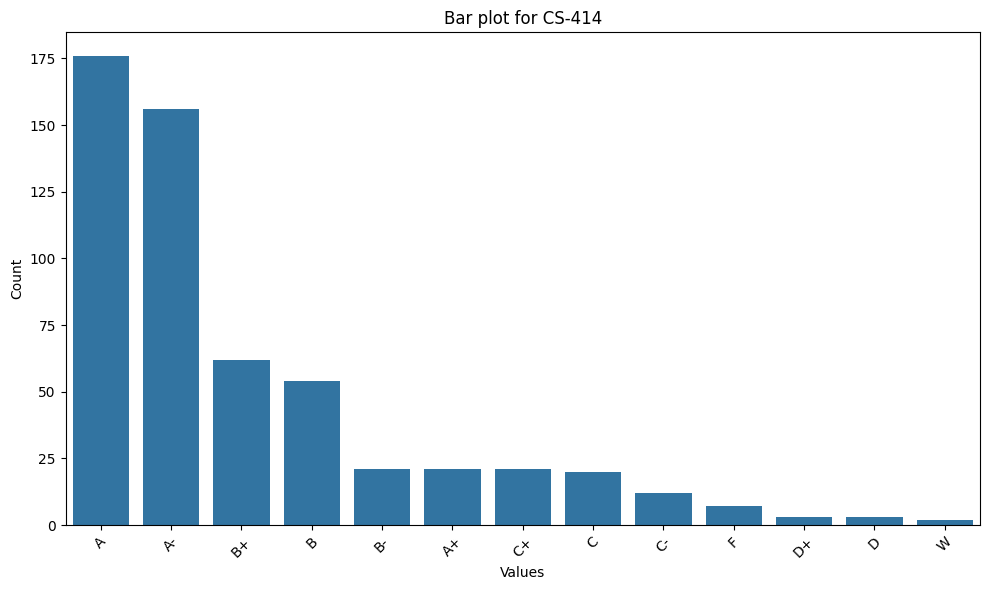

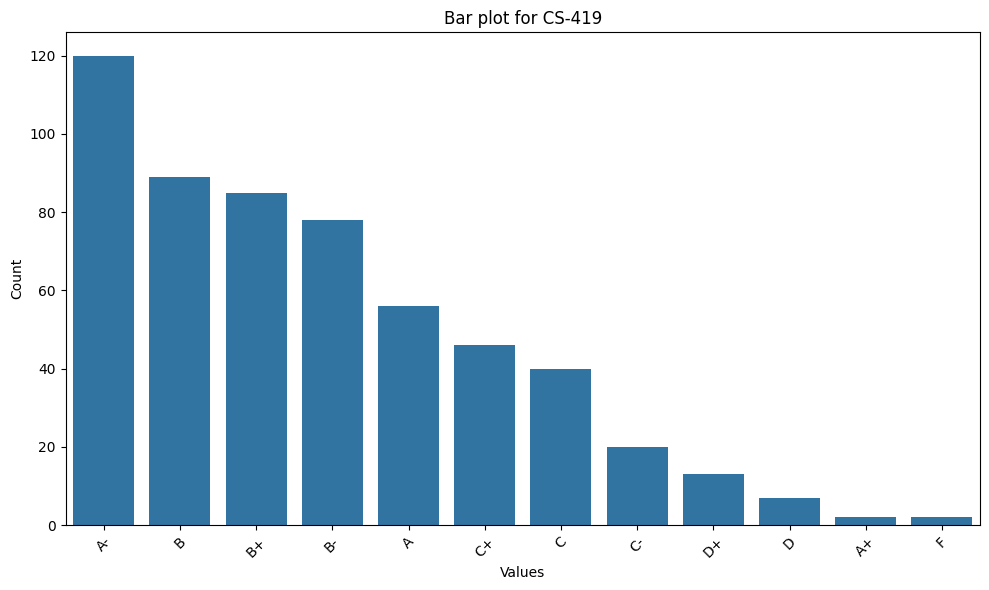

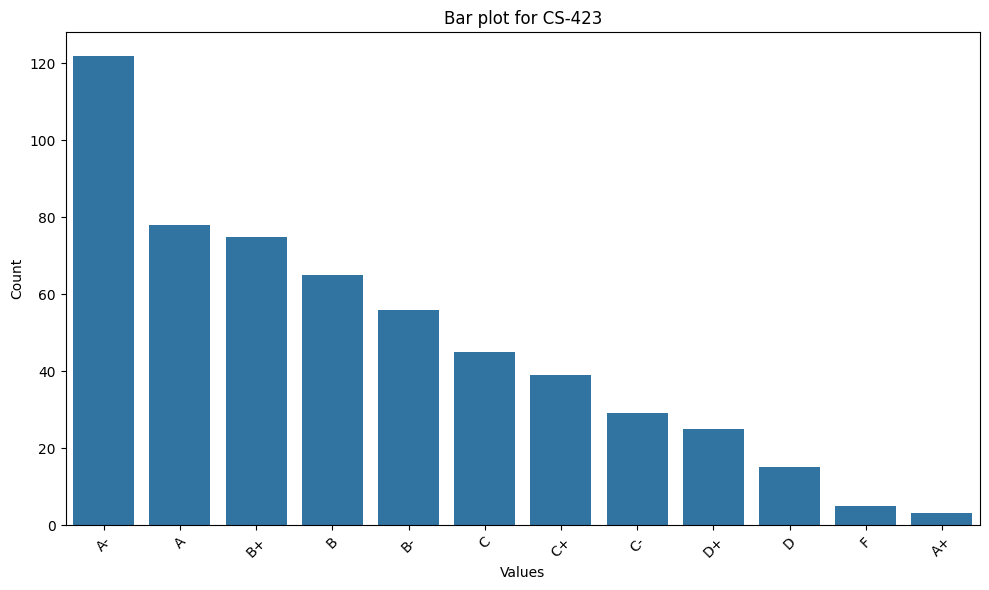

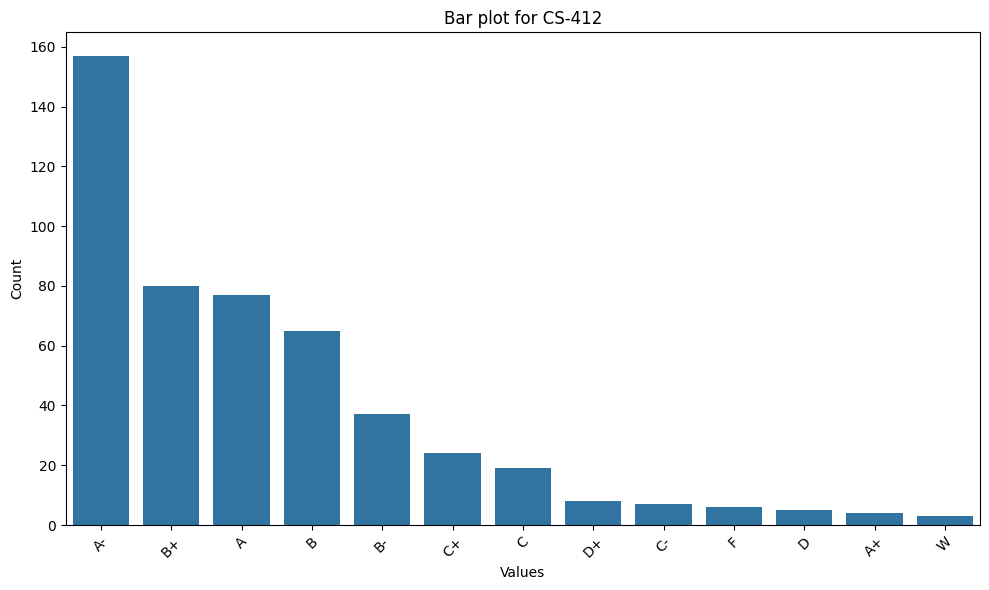

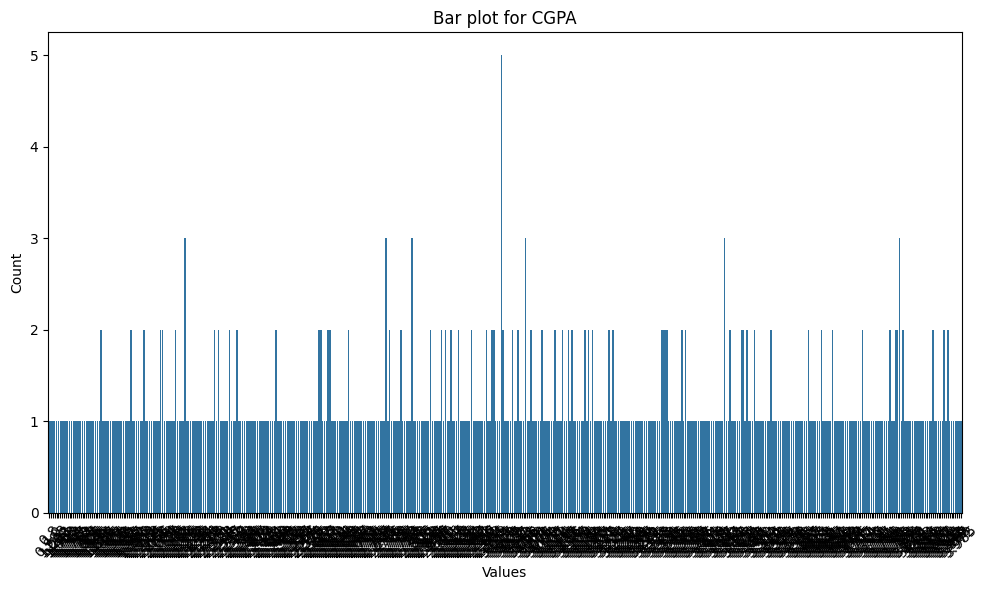

In [30]:

# Plot each column in the DataFrame
for column in df.columns:
    plt.figure(figsize=(10, 6))
    sns.barplot(x=df[column].value_counts().index, y=df[column].value_counts())
    plt.title(f'Bar plot for {column}')
    plt.xlabel('Values')
    plt.ylabel('Count')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()
    plt.show()

In [ ]:
Feature Engineering.

In [31]:
# Since df is DataFrame containing the dataset

if 'Seat No.' in df.columns:  # Check if 'Seat No' column exists
    # 1. Aggregating grades across all courses
    df['mode_grade'] = df.drop(['Seat No.', 'CGPA'], axis=1).mode(axis=1).iloc[:, 0]

    # 2. Calculating the number of courses taken by each student
    df['num_courses_taken'] = df.drop(['Seat No.', 'CGPA'], axis=1).count(axis=1)

    # Extract department information from 'Seat No' using regex
    df['Department'] = df['Seat No.'].apply(lambda x: re.match(r'^([A-Za-z]{2})', x).group(1))

    # Calculate mode grade for each department
    department_grades_mode = df.groupby('Department').agg(lambda x: x.mode().iloc[0]).add_suffix('_mode')
else:
    print("Column 'Seat No.' not found in DataFrame.")


In [32]:
grade_mapping = {
    'A+': 4.0,
    'A': 4.0,
    'A-': 3.75,
    'B+': 3.5,
    'B': 3.25,
    'B-': 3.0,
    'C+': 2.5,
    'C': 2.0,
    'C-': 1.5,
    'D+': 1.0,
    'D': 0.5,
    'D-': 0.25,  # Adjusted value for D-
    'F': 0.0  # Mapping F to 0.0
}

for index, grade in enumerate(df['mode_grade']):
    if grade in grade_mapping:
        df.loc[index, 'mode_grade'] = grade_mapping[grade]
    else:
        df.loc[index, 'mode_grade'] = 0.0


In [33]:
# Fill missing values with mode for categorical columns with missing data less than 20%
for column in df.columns:
    if df[column].isnull().any():
        missing_ratio = df[column].isnull().mean()
        if missing_ratio < 0.2 and df[column].dtype == object:  # Check if the column is categorical
            mode_value = df[column].mode().iloc[0]  # Calculate the mode value of the column
            df[column].fillna(mode_value, inplace=True)

# Drop columns with missing data above 25%
missing_ratios = df.isnull().mean()
columns_to_drop = missing_ratios[missing_ratios > 0.25].index
df.drop(columns_to_drop, axis=1, inplace=True)

In [34]:
df

,Seat No.,PH-121,HS-101,CY-105,HS-105/12,MT-111,CS-105,CS-106,EL-102,EE-119,...,CS-421,CS-406,CS-414,CS-419,CS-423,CS-412,CGPA,mode_grade,num_courses_taken,Department
0,CS-97001,B-,D+,C-,C,C-,D+,D,C-,B-,...,C-,A-,A,C-,B,A-,2.205,1.5,42,CS
1,CS-97002,A,D,D+,D,B-,C,D,A,D+,...,D,A-,B-,C,C,B,2.008,0.5,42,CS
2,CS-97003,A,B,A,B-,B+,A,B-,B+,A-,...,C,A,A,A,A-,A,3.608,4.0,42,CS
3,CS-97004,D,C+,D+,D,D,A-,D+,C-,D,...,C-,B-,B,C+,C+,C+,1.906,0.5,42,CS
4,CS-97005,A-,A-,A-,B+,A,A,A-,B+,A,...,B-,A-,A,A-,A-,A,3.448,3.75,42,CS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
566,CS-97567,B,A,A,A-,A+,A,A-,A-,A+,...,A,A,B+,B+,B,A,3.798,4.0,42,CS
567,CS-97568,A+,A,A,A,A,A,A,A-,A,...,A,A-,B,A-,C,A-,3.772,4.0,42,CS
568,CS-97569,B,A,A-,B+,A,A,A,A,A,...,B+,A,C,B+,A-,A-,3.470,4.0,42,CS
569,CS-97570,A,B+,D,A,D,D+,B-,C-,B-,...,C-,D,C,B,B-,C,2.193,0.5,42,CS


In [35]:
# Set the random seed
np.random.seed(42)
X = df[['mode_grade', 'num_courses_taken']]
y = df['CGPA']
scaler = StandardScaler()
X_scaler = scaler.fit_transform(X)

# Split the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X_scaler, y, test_size=0.2, random_state=42)


In [36]:
y.value_counts()

CGPA
3.019    5
3.058    3
2.793    3
3.443    3
2.206    3
        ..
2.555    1
2.042    1
2.634    1
2.053    1
1.753    1
Name: count, Length: 491, dtype: int64

In [37]:
# Print the shapes of the training and testing sets to verify the split
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (456, 2)
Shape of X_test: (115, 2)
Shape of y_train: (456,)
Shape of y_test: (115,)


In [38]:
# Modelling
random_state = 45

# Define models
grad_boost_model = GradientBoostingRegressor(random_state=random_state)
svm_model = SVR(kernel='linear')

# Define k-fold cross-validation
k_fold = KFold(n_splits=5, shuffle=True, random_state=random_state)

# Perform k-fold cross-validation for Gradient Boosting Regression
grad_boost_scores = cross_val_score(grad_boost_model, X_train, y_train, cv=k_fold, scoring='neg_mean_squared_error')
grad_boost_mse = -grad_boost_scores.mean()  # Convert negative MSE to positive
grad_boost_r2 = cross_val_score(grad_boost_model, X_train, y_train, cv=k_fold, scoring='r2').mean()

# Perform k-fold cross-validation for Support Vector Machine (SVM)
svm_scores = cross_val_score(svm_model, X_train, y_train, cv=k_fold, scoring='neg_mean_squared_error')
svm_mse = -svm_scores.mean()  # Convert negative MSE to positive
svm_r2 = cross_val_score(svm_model, X_train, y_train, cv=k_fold, scoring='r2').mean()

# Print the results
print("Gradient Boosting Regression:")
print(f"  Mean Squared Error: {grad_boost_mse:.4f}")
print(f"  R-squared: {grad_boost_r2:.4f}")
print("\nSupport Vector Machine (SVM):")
print(f"  Mean Squared Error: {svm_mse:.4f}")
print(f"  R-squared: {svm_r2:.4f}")

Gradient Boosting Regression:
  Mean Squared Error: 0.0975
  R-squared: 0.7534

Support Vector Machine (SVM):
  Mean Squared Error: 0.1216
  R-squared: 0.6893


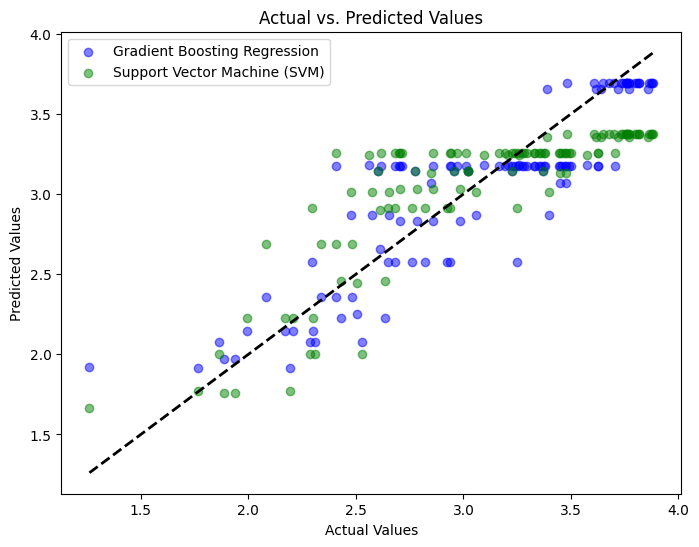

In [39]:
# Define models (assuming they have been trained already)
grad_boost_model = GradientBoostingRegressor(random_state=random_state)
svm_model = SVR(kernel='linear')

# Train the models (assuming X_train and y_train are defined)
grad_boost_model.fit(X_train, y_train)
svm_model.fit(X_train, y_train)

# Predictions
y_pred_grad_boost = grad_boost_model.predict(X_test)
y_pred_svm = svm_model.predict(X_test)

# Plot actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_grad_boost, color='blue', alpha=0.5, label='Gradient Boosting Regression')
plt.scatter(y_test, y_pred_svm, color='green', alpha=0.5, label='Support Vector Machine (SVM)')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line for reference
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()

The Mean Squared Error (MSE) evaluates the average squared difference between predicted values and actual values.
A lower MSE implies that the model's predictions closely align with the actual values, which is desirable. Comparing the two models,
the Gradient Boosting Regression model exhibits a lower MSE of 0.0975, while the SVM model yields a slightly higher MSE of 0.1216.
This suggests that the Gradient Boosting Regression model outperforms the SVM model in minimizing the squared differences between predictions
and actual values.

R-squared represents the proportion of the variance in the dependent variable (target) that is predictable from the independent variables (features). 
It ranges from 0 to 1, with higher values indicating a better fit of the model to the data. An R-squared of 1 indicates a perfect fit. In this case, 
the Gradient Boosting Regression model has a higher R-squared (0.7534) compared to the SVM model (0.6893).
This suggests that the Gradient-boosting regression model explains a larger proportion of the variance in the target variable and therefore fits 
the data better.
    